In [7]:
#| default_exp analytic_curves
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from sympy import *
from typing import Tuple
from functools import partial
import diffusion_curvature
from diffusion_curvature.core import plot_3d, diffusion_matrix, gaussian_kernel
from diffusion_curvature.curves import *
from diffusion_curvature.datasets import *
# Reload any changes made to external files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analytic form of the Local Diffusion Entropy

Ahmed and Gokhale (cited by Wikipedia) have proven that the *differential entropy* of the multivariate gaussian is 

$$
\frac{k}{2}+\frac{k}{2} \ln (2 \pi)+\frac{1}{2} \ln (|\boldsymbol{\Sigma}|)
$$

where $k$ is the dimension of the space, and $|\Sigma|$ is the determinant of the covariance matrix. Does this match our computation about?

Note that in the heat kernel, the bandwidth is uniform throughout all dimensions (i.e. is a diagonal matrix), with determinant equal to $2^k t^k$, rendering this

$$
\frac{d}{2}+\frac{d}{2} \ln (2 \pi)+\frac{1}{2} \ln (2^d t^d)
$$

In [8]:
def differential_entropy_of_euclidean_heat_kernel(dim, t, scaling_factor=1, time_offset=0):
    """Accepts vectorized t as input"""
    return dim/2 + (dim/2)*(np.log(2*np.pi))+(1/2)*np.log(2**dim*(scaling_factor*(t)+time_offset)**dim)

# Automatic Scaling by the entropy invariance principle

In [9]:
import numpy as np
def time_of_entropy(h, dimension):
    """Gives the time that would produce the specified entropy"""
    return ((np.exp(2*(h - dimension/2 - (dimension/2)*np.log(2*np.pi))))/(2**dimension))**(1/dimension)

def autoscale_by_entropy(
        target_dist:np.ndarray, # the curvature curve to fit 
        dimension:int # the manifold's intrinsic dimension
        ):
    h_start = target_dist[0]
    h_stop = target_dist[-1]
    t_start = time_of_entropy(h_start,dimension=dimension)
    t_stop = time_of_entropy(h_stop,dimension=dimension)
    scaling_factor = (t_stop - t_start)/(len(target_dist) - 1)
    scaled_differential_entropy = partial(differential_entropy_of_euclidean_heat_kernel,scaling_factor = scaling_factor, time_offset = t_start)
    return scaled_differential_entropy, scaling_factor, t_start

In [10]:
h_test = 6
t_test = time_of_entropy(h_test,dimension=2)
assert h_test == differential_entropy_of_euclidean_heat_kernel(dim=2,t=t_test)

Here are some discretely sampled distributions, matched to this analytic curve by this simple scaling method.

In [11]:
def plot_scaled_entropies(X, idx = 0, dim=2, dataset_name = "", **kwargs):
    entropies = rate_of_change_of_entropy(X, **kwargs)
    entropies_of_point = entropies[idx]
    scaled_diffh, scale_factor, start_t = autoscale_by_entropy(entropies_of_point, dimension=dim)
    ts = np.arange(len(entropies_of_point))
    fitted_analytic = scaled_diffh

    plt.plot(ts, fitted_analytic(t=ts, dim=2), label="continuous")
    plt.plot(ts, entropies_of_point, label=f"discrete {dataset_name}")
    plt.xlabel("time (scaled)")
    plt.ylabel("Entropy of Diffusion")
    plt.title(f"Curvature Curves: Fitted to {dataset_name}")
    plt.legend()

    return {
        "fitted analytic":fitted_analytic,
        "scale factor":scale_factor,
        "start t":start_t,
        "entropies of point":entropies_of_point
    }

0it [00:00, ?it/s]

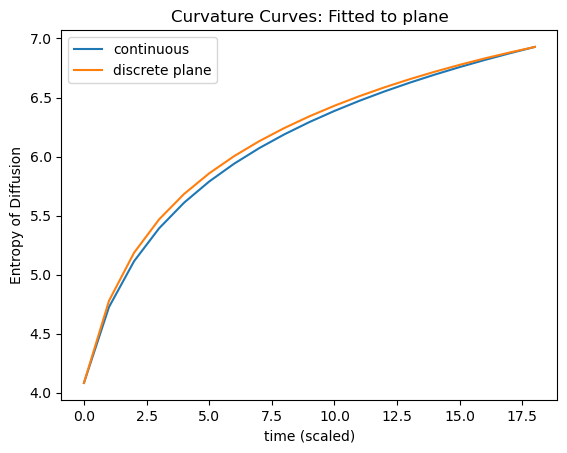

In [21]:
X_plane = plane(2000)
deets = plot_scaled_entropies(X_plane, dataset_name="plane", max=20)

In [13]:
from diffusion_curvature.gaussian_invariance import compute_anisotropic_diffusion_matrix_from_graph
A = gaussian_kernel(X_plane, kernel_type="adaptive",k=10)
P_plane = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)

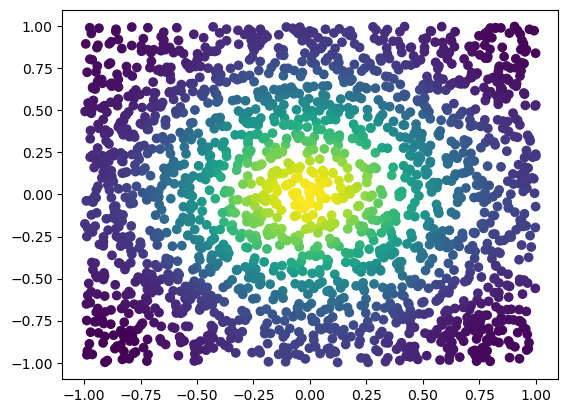

In [20]:
Pt_plane = np.linalg.matrix_power(P_plane,40)
plt.scatter(X_plane[:,0],X_plane[:,1],c=Pt_plane[0])

In [24]:
X_sphere, ks_sphere = sphere(n=2000, use_guide_points=True)
X_saddle, ks_saddle = paraboloid(n=2000, use_guide_points=True)

0it [00:00, ?it/s]

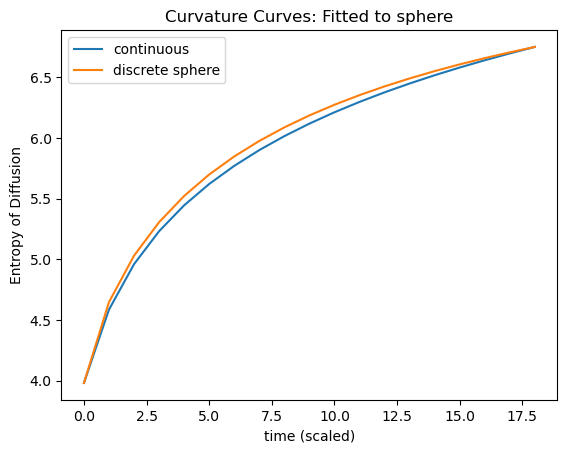

In [20]:
deets_sphere = plot_scaled_entropies(X_sphere, dataset_name="sphere", max=20)

0it [00:00, ?it/s]

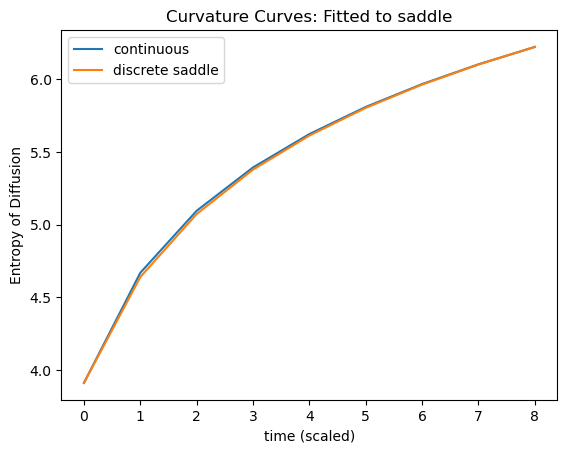

In [29]:
deets_saddle = plot_scaled_entropies(X_saddle, dataset_name="saddle",max=10)

## Checking the form of the diffusions
How spread out are they?

In [23]:
from diffusion_curvature.gaussian_invariance import compute_anisotropic_diffusion_matrix_from_graph
A = gaussian_kernel(X_sphere, kernel_type="adaptive",k=10)
P_sphere = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)

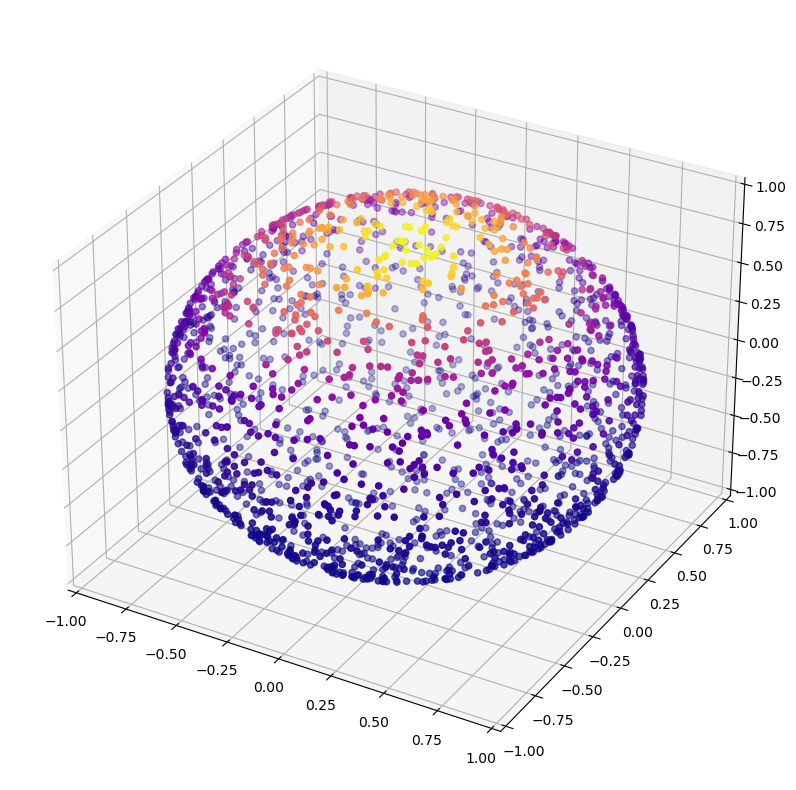

In [24]:
Pt_sphere = np.linalg.matrix_power(P,20)
plot_3d(X_sphere,Pt[0])

In [25]:
from diffusion_curvature.gaussian_invariance import compute_anisotropic_diffusion_matrix_from_graph
A = gaussian_kernel(X_saddle, kernel_type="adaptive",k=10)
P_saddle = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)

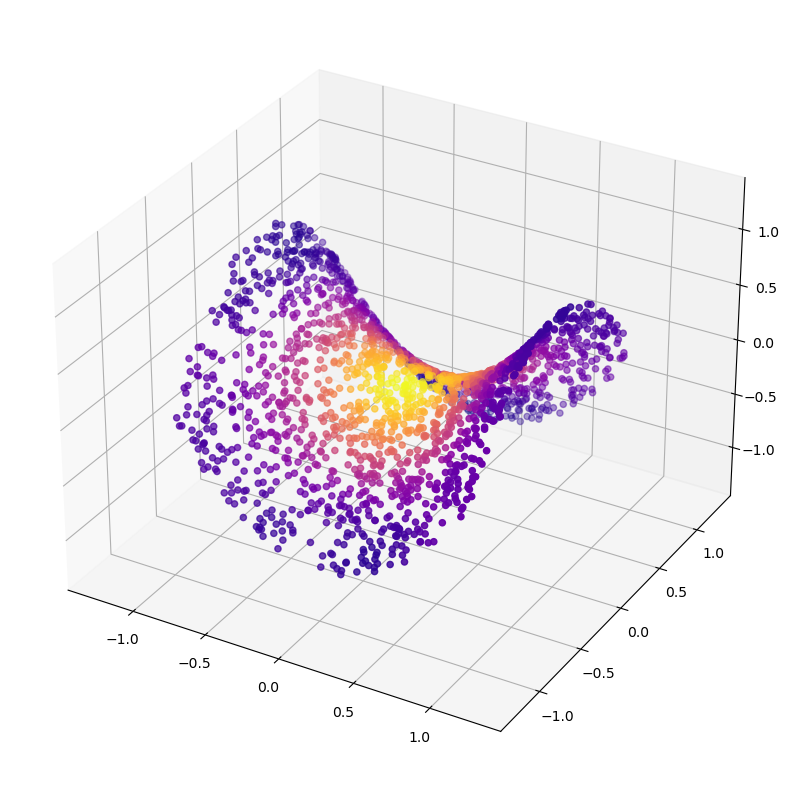

In [31]:
Pt_saddle = np.linalg.matrix_power(P_saddle,50)
plot_3d(X_saddle,Pt_saddle[0])

# Trying on the Torus

In [121]:
X_torus, ks_torus = torus(n=4000,use_guide_points=True)
len(X_torus)

2045

In [122]:
A = gaussian_kernel(X_torus, kernel_type="adaptive",k=10)
P_torus = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)

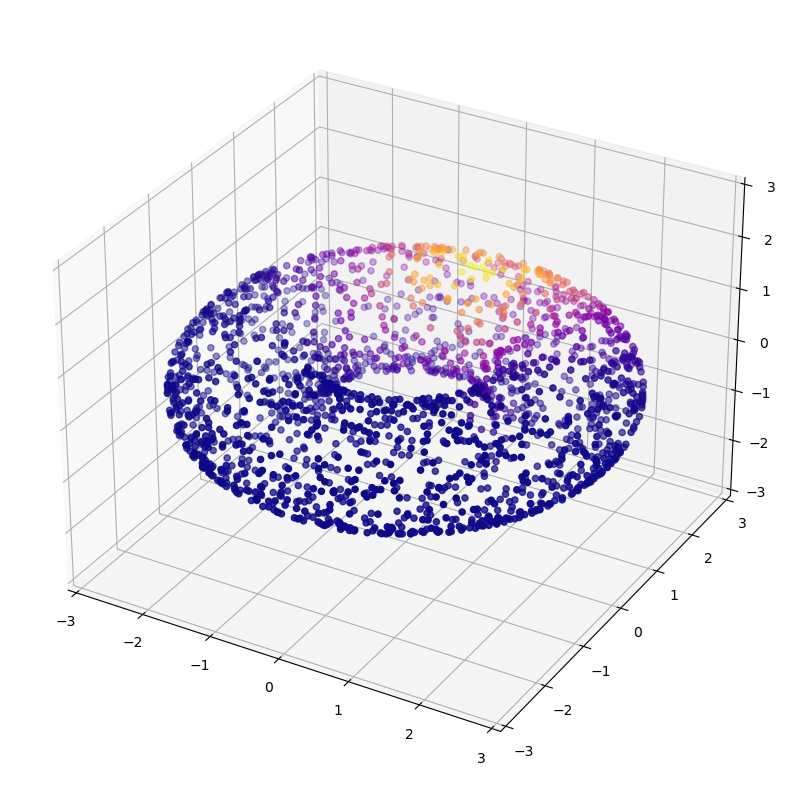

In [123]:
Pt_torus = np.linalg.matrix_power(P_torus,10)
plot_3d(X_torus,Pt_torus[2])

In [124]:
plot_scaled_entropies(X_torus,idx=0, dataset_name="Positive region of Torus",max=10)

0it [00:00, ?it/s]

KeyboardInterrupt: 

0it [00:00, ?it/s]

{'fitted analytic': functools.partial(<function differential_entropy_of_euclidean_heat_kernel at 0x107bf5990>, scaling_factor=2.228671638036438, time_offset=1.5651169476732516),
 'scale factor': 2.228671638036438,
 'start t': 1.5651169476732516,
 'entropies of point': array([3.9789848 , 4.7825316 , 5.24608495, 5.57420422, 5.83047701,
        6.04055255, 6.21700031, 6.36717062, 6.49601325])}

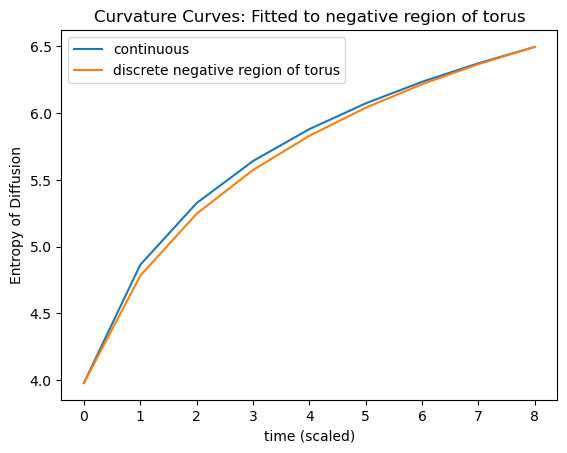

In [52]:
plot_scaled_entropies(X_torus, idx=1, dataset_name="negative region of torus",max=10)

0it [00:00, ?it/s]

{'fitted analytic': functools.partial(<function differential_entropy_of_euclidean_heat_kernel at 0x107bf5990>, scaling_factor=1.675113696852474, time_offset=2.0937705173837053),
 'scale factor': 1.675113696852474,
 'start t': 2.0937705173837053,
 'entropies of point': array([4.26999076, 4.87108843, 5.24134618, 5.51015233, 5.72047261,
        5.8927536 , 6.03801949, 6.16284484, 6.27152099])}

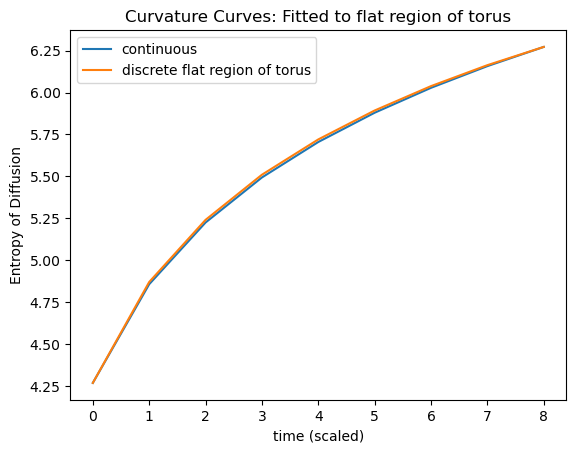

In [53]:
plot_scaled_entropies(X_torus, idx=2, dataset_name="flat region of torus",max=10)

# Comparing the derivatives

In [22]:
def deriv_of_entropies(
        hs:np.ndarray # entropies over time, assumed to be evenly spaced
        ):
    return hs[1:] - hs[:-1]

In [28]:
entropies_sphere = rate_of_change_of_entropy(X_sphere)[0]
sphere_hs_derivs = deriv_of_entropies(entropies_sphere)

0it [00:00, ?it/s]

In [29]:
entropies_saddle = rate_of_change_of_entropy(X_saddle)[0]
saddle_hs_derivs = deriv_of_entropies(entropies_saddle)

0it [00:00, ?it/s]

In [33]:
entropies_plane = rate_of_change_of_entropy(X_plane)[0]
plane_hs_derivs = deriv_of_entropies(entropies_plane)

0it [00:00, ?it/s]

In [125]:
entropies_torus_positive = rate_of_change_of_entropy(X_torus,max=30)[0]

0it [00:00, ?it/s]

In [126]:
entropies_torus_negative = rate_of_change_of_entropy(X_torus,max=30)[1]

0it [00:00, ?it/s]

In [127]:
entropies_torus_zero = rate_of_change_of_entropy(X_torus,max=30)[2]

0it [00:00, ?it/s]

# Fitting the curve directly

In [42]:
ts = np.arange(0.1,50,0.1)
analytic_curve = differential_entropy_of_euclidean_heat_kernel(dim=2, t=ts)

In [55]:
def fittable_logarithmic_curve(t, a, b, c):
    return a + b*np.log(c*t)

In [147]:
def fittable_logarithmic_curve_with_offset(t, a, b, c, d, dim=2):
    return dim/2+dim*np.log(2*np.pi)/2 + np.log(c*t + d)

In [59]:
import scipy
params, cov = scipy.optimize.curve_fit(fittable_logarithmic_curve, ts, analytic_curve)
print(f" Using a,b,c = {params}")

 Using a,b,c = [3.53102424 1.         1.        ]


In [60]:
fitted_curve = fittable_logarithmic_curve(ts, *params)

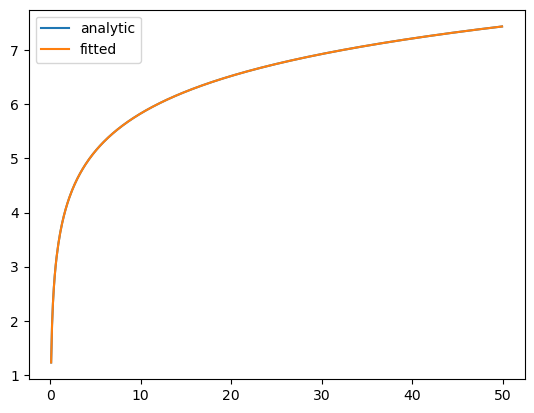

In [61]:
import matplotlib.pyplot as plt
plt.plot(ts, analytic_curve, label="analytic")
plt.plot(ts, fitted_curve, label="fitted")
plt.legend()

The fitting worked perfectly. But how does it do with different curvatures?

Here's the plane

 Using a,b,c = [2.17081406 0.93195626 8.50508881]


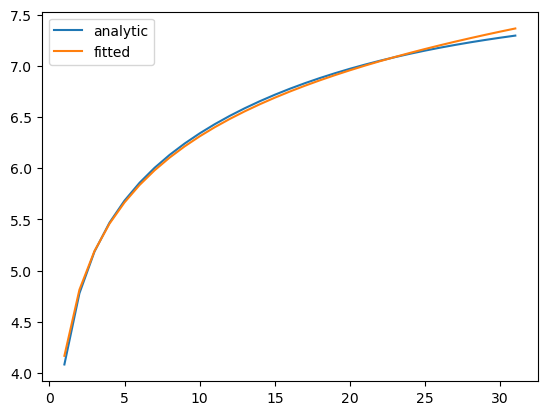

In [67]:
analytic_curve = entropies_plane
ts = np.arange(1,len(analytic_curve)+1)
params, cov = scipy.optimize.curve_fit(fittable_logarithmic_curve, ts, entropies_plane)
fitted_curve = fittable_logarithmic_curve(ts, *params)
print(f" Using a,b,c = {params}")
plt.plot(ts, analytic_curve, label="analytic")
plt.plot(ts, fitted_curve, label="fitted")
plt.legend()

Notably, even the flat case requires considerable stretching - and doesn't give a perfect fit afterwards. If these parameters are *indeed* the best possible fit of the flat region, then the discrete case differs from the analytic curve by every parameter: the rate of time (c), the exponential increase (b), and the absolute values (a).

 Using a,b,c = [3.49998927 0.89096314 1.96395696]


/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_6622/2459004474.py:2: RuntimeWarning: invalid value encountered in log
  return a + b*np.log(c*t)


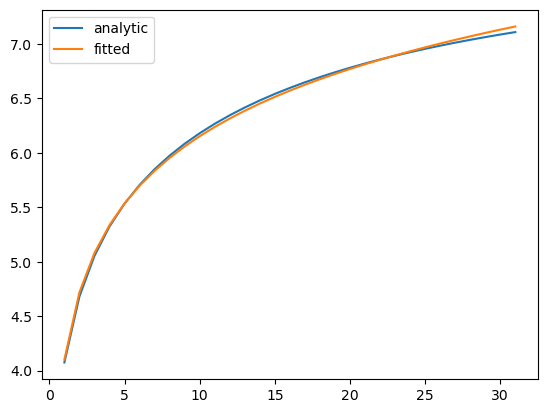

In [69]:
analytic_curve = entropies_sphere
ts = np.arange(1,len(analytic_curve)+1)
params, cov = scipy.optimize.curve_fit(fittable_logarithmic_curve, ts, analytic_curve)
fitted_curve = fittable_logarithmic_curve(ts, *params)
print(f" Using a,b,c = {params}")
plt.plot(ts, analytic_curve, label="analytic")
plt.plot(ts, fitted_curve, label="fitted")
plt.legend()

 Using a,b,c = [1.89472554 0.966622   9.41915463]


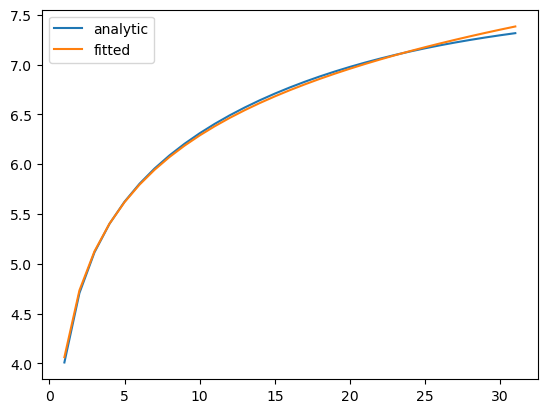

In [70]:
analytic_curve = entropies_saddle
ts = np.arange(1,len(analytic_curve)+1)
params, cov = scipy.optimize.curve_fit(fittable_logarithmic_curve, ts, analytic_curve)
fitted_curve = fittable_logarithmic_curve(ts, *params)
print(f" Using a,b,c = {params}")
plt.plot(ts, analytic_curve, label="analytic")
plt.plot(ts, fitted_curve, label="fitted")
plt.legend()

## Intra-dataset comparison with the torus

In the above cases, a consistent comparison is confounded by inconsistent sampling. Are things more feasible if we examine different regions of the same manifold?

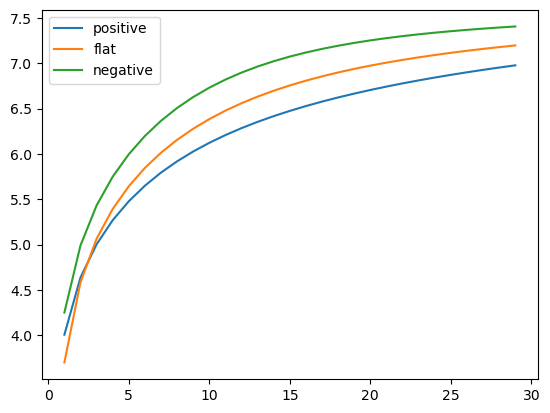

In [130]:
ts = np.arange(1,len(entropies_torus_negative)+1)
plt.plot(ts,entropies_torus_positive,label="positive")
plt.plot(ts,entropies_torus_zero,label="flat")
plt.plot(ts, entropies_torus_negative, label="negative")
plt.legend()

 Using a,b,c = [2.11093791 0.88485087 8.96669024]


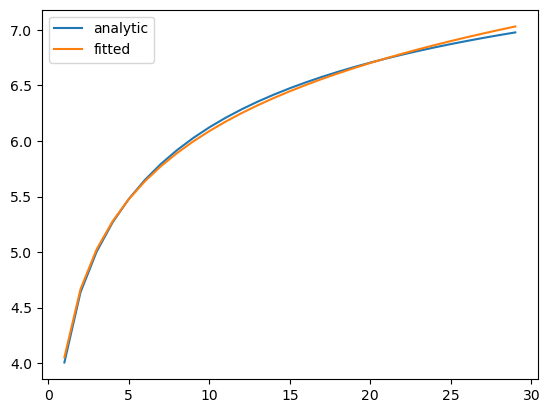

In [131]:
analytic_curve = entropies_torus_positive
ts = np.arange(1,len(analytic_curve)+1)
params, cov = scipy.optimize.curve_fit(fittable_logarithmic_curve, ts, analytic_curve)
fitted_curve = fittable_logarithmic_curve(ts, *params)
print(f" Using a,b,c = {params}")
plt.plot(ts, analytic_curve, label="analytic")
plt.plot(ts, fitted_curve, label="fitted")
plt.legend()

 Using a,b,c = [3.26430498 1.00534767 2.01011961]


/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_6622/2459004474.py:2: RuntimeWarning: invalid value encountered in log
  return a + b*np.log(c*t)


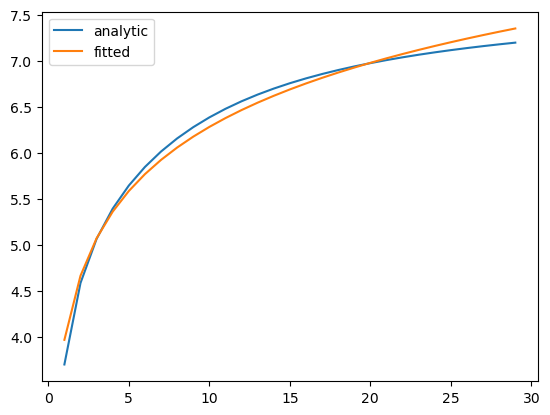

In [132]:
analytic_curve = entropies_torus_zero
ts = np.arange(1,len(analytic_curve)+1)
params, cov = scipy.optimize.curve_fit(fittable_logarithmic_curve, ts, analytic_curve)
fitted_curve = fittable_logarithmic_curve(ts, *params)
print(f" Using a,b,c = {params}")
plt.plot(ts, analytic_curve, label="analytic")
plt.plot(ts, fitted_curve, label="fitted")
plt.legend()

 Using a,b,c = [3.78385847 0.92887995 2.08618193]


/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_6622/2459004474.py:2: RuntimeWarning: invalid value encountered in log
  return a + b*np.log(c*t)


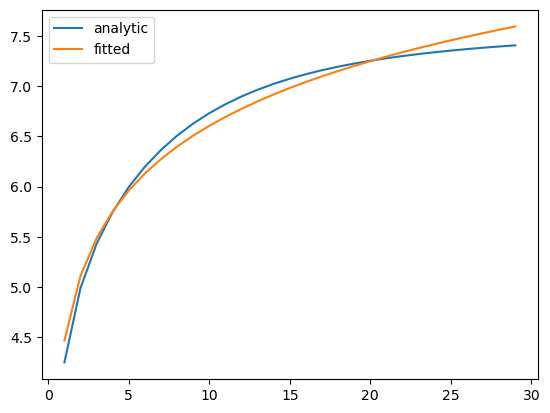

In [133]:
analytic_curve = entropies_torus_negative
ts = np.arange(1,len(analytic_curve)+1)
params, cov = scipy.optimize.curve_fit(fittable_logarithmic_curve, ts, analytic_curve)
fitted_curve = fittable_logarithmic_curve(ts, *params)
print(f" Using a,b,c = {params}")
plt.plot(ts, analytic_curve, label="analytic")
plt.plot(ts, fitted_curve, label="fitted")
plt.legend()

### With a fixed exponent and flexible offset

 Using a,b,c = [1.         1.         1.1333864  0.58479148 2.52245852]


/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_6622/803900341.py:2: RuntimeWarning: invalid value encountered in log
  return dim/2+dim*np.log(2*np.pi)/2 + np.log(c*t + d)
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


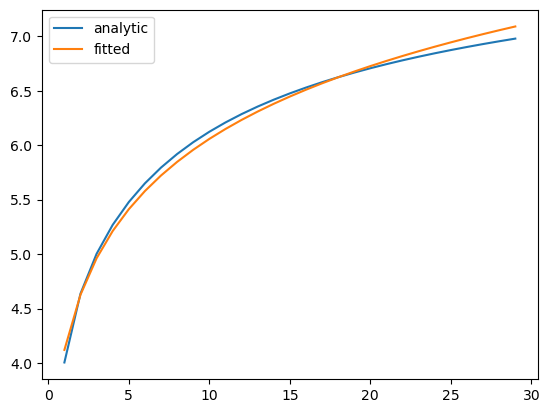

In [148]:
analytic_curve = entropies_torus_positive
ts = np.arange(1,len(analytic_curve)+1)
params, cov = scipy.optimize.curve_fit(fittable_logarithmic_curve_with_offset, ts, analytic_curve)
fitted_curve = fittable_logarithmic_curve_with_offset(ts, *params)
print(f" Using a,b,c = {params}")
plt.plot(ts, analytic_curve, label="analytic")
plt.plot(ts, fitted_curve, label="fitted")
plt.legend()

 Using a,b,c = [ 1.          1.          2.01345807 -0.43039073  2.33283521]


/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_6622/803900341.py:2: RuntimeWarning: invalid value encountered in log
  return dim/2+dim*np.log(2*np.pi)/2 + np.log(c*t + d)


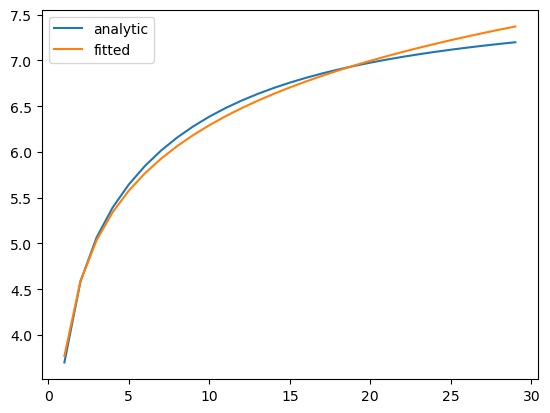

In [149]:
analytic_curve = entropies_torus_zero
ts = np.arange(1,len(analytic_curve)+1)
params, cov = scipy.optimize.curve_fit(fittable_logarithmic_curve_with_offset, ts, analytic_curve)
fitted_curve = fittable_logarithmic_curve_with_offset(ts, *params)
print(f" Using a,b,c = {params}")
plt.plot(ts, analytic_curve, label="analytic")
plt.plot(ts, fitted_curve, label="fitted")
plt.legend()

 Using a,b,c = [ 3.3264011   0.81200131  6.3199752  -3.41452044]


/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_6622/1469637754.py:2: RuntimeWarning: invalid value encountered in log
  return a + b*np.log(c*t + d)


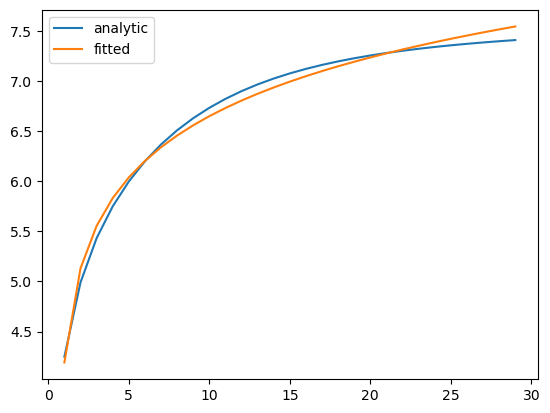

In [143]:
analytic_curve = entropies_torus_negative
ts = np.arange(1,len(analytic_curve)+1)
params, cov = scipy.optimize.curve_fit(fittable_logarithmic_curve_with_offset, ts, analytic_curve)
fitted_curve = fittable_logarithmic_curve_with_offset(ts, *params)
print(f" Using a,b,c = {params}")
plt.plot(ts, analytic_curve, label="analytic")
plt.plot(ts, fitted_curve, label="fitted")
plt.legend()